In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params)
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()), lr= args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo

In [9]:
def validate_vae(args, encoder, target, transitions, dataset):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 1 	 Current ELBO train: -785.1300659179688
Best elbo validation -783.2388
Current elbo validation -783.2388
Saved samples to ./pics/mnist_epoch_0_K_1_N_1_amortize_False.png


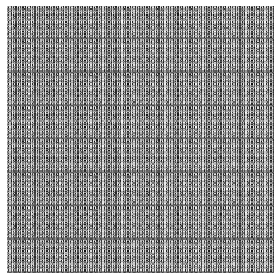

  0%|          | 1/1000 [00:32<9:00:56, 32.49s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
Current epoch: 2 	 Current ELBO train: -775.1421508789062
Best elbo validation -772.81824
Current elbo validation -772.81824
Saved samples to ./pics/mnist_epoch_1_K_1_N_1_amortize_False.png


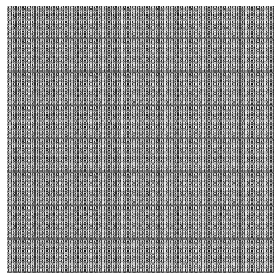

  0%|          | 2/1000 [01:05<9:00:43, 32.51s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
Current epoch: 3 	 Current ELBO train: -768.8294067382812
Best elbo validation -767.926
Current elbo validation -767.926
Saved samples to ./pics/mnist_epoch_2_K_1_N_1_amortize_False.png


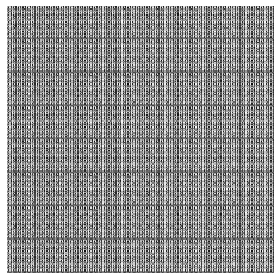

  0%|          | 3/1000 [01:37<9:00:56, 32.55s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 4 	 Current ELBO train: -762.203125
Best elbo validation -762.598
Current elbo validation -762.598
Saved samples to ./pics/mnist_epoch_3_K_1_N_1_amortize_False.png


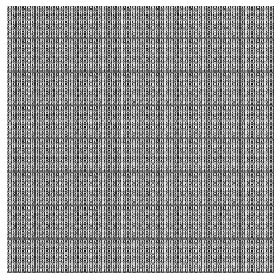

  0%|          | 4/1000 [02:10<9:00:56, 32.59s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 301/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 5 	 Current ELBO train: -757.4481201171875
Best elbo validation -760.38434
Current elbo validation -760.38434
Saved samples to ./pics/mnist_epoch_4_K_1_N_1_amortize_False.png


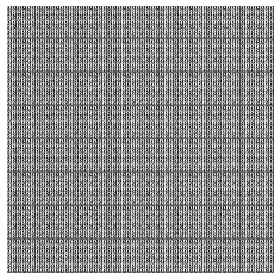

  0%|          | 5/1000 [02:43<9:00:54, 32.62s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 6 	 Current ELBO train: -761.5958251953125
Best elbo validation -758.0195
Current elbo validation -758.0195
Saved samples to ./pics/mnist_epoch_5_K_1_N_1_amortize_False.png


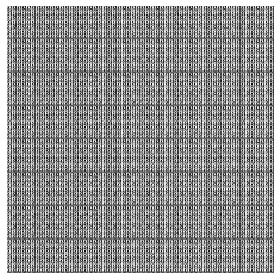

  1%|          | 6/1000 [03:15<9:00:32, 32.63s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
Current epoch: 7 	 Current ELBO train: -754.9559326171875
Best elbo validation -756.8761
Current elbo validation -756.8761
Saved samples to ./pics/mnist_epoch_6_K_1_N_1_amortize_False.png


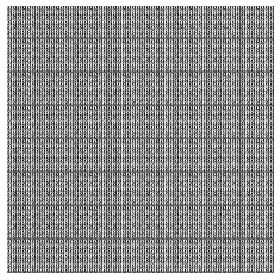

  1%|          | 7/1000 [03:48<9:00:16, 32.65s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 501/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
Current epoch: 8 	 Current ELBO train: -756.3914794921875
Best elbo validation -755.7642
Current elbo validation -755.7642
Saved samples to ./pics/mnist_epoch_7_K_1_N_1_amortize_False.png


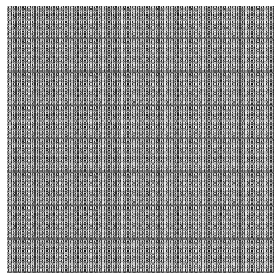

  1%|          | 8/1000 [04:21<8:59:48, 32.65s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 9 	 Current ELBO train: -229.59976196289062
Best elbo validation -233.18031
Current elbo validation -233.18031
Saved samples to ./pics/mnist_epoch_8_K_1_N_1_amortize_False.png


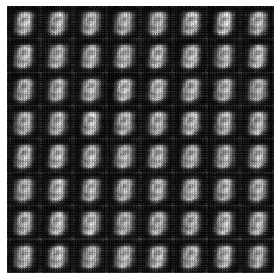

  1%|          | 9/1000 [04:53<8:59:57, 32.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 10 	 Current ELBO train: -218.63800048828125
Best elbo validation -215.54425
Current elbo validation -215.54425
Saved samples to ./pics/mnist_epoch_9_K_1_N_1_amortize_False.png


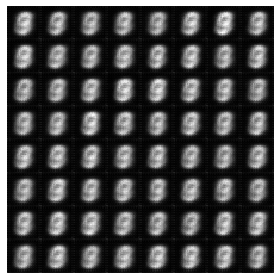

  1%|          | 10/1000 [05:26<9:00:01, 32.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
Current epoch: 11 	 Current ELBO train: -213.4080047607422
Best elbo validation -215.21059
Current elbo validation -215.21059
Saved samples to ./pics/mnist_epoch_10_K_1_N_1_amortize_False.png


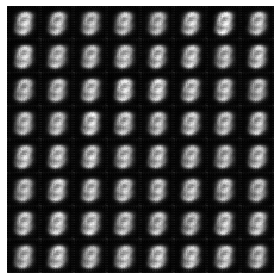

  1%|          | 11/1000 [05:59<8:59:14, 32.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 12 	 Current ELBO train: -211.54452514648438
Best elbo validation -214.13164
Current elbo validation -214.13164
Saved samples to ./pics/mnist_epoch_11_K_1_N_1_amortize_False.png


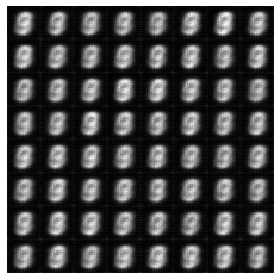

  1%|          | 12/1000 [06:31<8:58:25, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 13 	 Current ELBO train: -211.64010620117188
Best elbo validation -213.70053
Current elbo validation -213.70053
Saved samples to ./pics/mnist_epoch_12_K_1_N_1_amortize_False.png


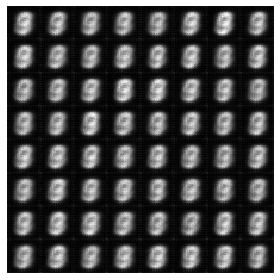

  1%|▏         | 13/1000 [07:04<8:57:39, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 14 	 Current ELBO train: -211.24501037597656
Best elbo validation -213.50607
Current elbo validation -213.50607
Saved samples to ./pics/mnist_epoch_13_K_1_N_1_amortize_False.png


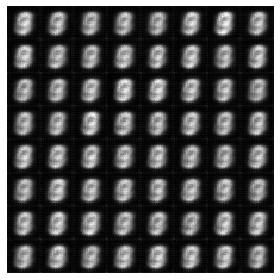

  1%|▏         | 14/1000 [07:37<8:57:02, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 501/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
Current epoch: 15 	 Current ELBO train: -216.07577514648438
Best elbo validation -212.98167
Current elbo validation -212.98167
Saved samples to ./pics/mnist_epoch_14_K_1_N_1_amortize_False.png


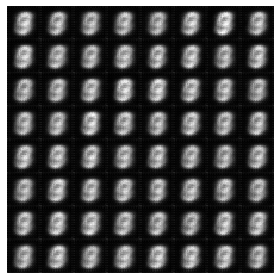

  2%|▏         | 15/1000 [08:10<8:56:31, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 16 	 Current ELBO train: -217.49180603027344
Best elbo validation -212.9618
Current elbo validation -212.9618
Saved samples to ./pics/mnist_epoch_15_K_1_N_1_amortize_False.png


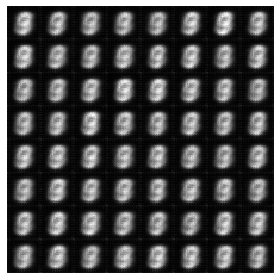

  2%|▏         | 16/1000 [08:42<8:55:52, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
Current epoch: 17 	 Current ELBO train: -216.03579711914062
Best elbo validation -212.83012
Current elbo validation -212.83012
Saved samples to ./pics/mnist_epoch_16_K_1_N_1_amortize_False.png


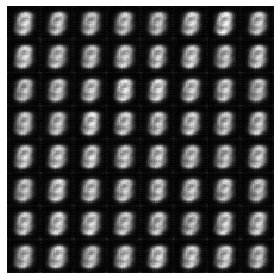

  2%|▏         | 17/1000 [09:15<8:55:14, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 18 	 Current ELBO train: -213.23663330078125
Best elbo validation -212.29256
Current elbo validation -212.29256
Saved samples to ./pics/mnist_epoch_17_K_1_N_1_amortize_False.png


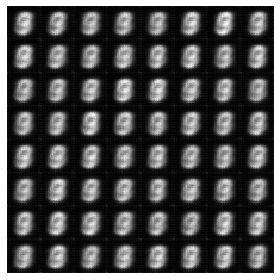

  2%|▏         | 18/1000 [09:48<8:54:45, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
Current epoch: 19 	 Current ELBO train: -187.48912048339844
Best elbo validation -193.14272
Current elbo validation -193.14272
Saved samples to ./pics/mnist_epoch_18_K_1_N_1_amortize_False.png


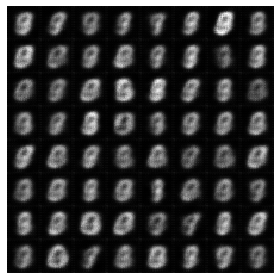

  2%|▏         | 19/1000 [10:20<8:54:45, 32.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 20 	 Current ELBO train: -181.77301025390625
Best elbo validation -182.55916
Current elbo validation -182.55916
Saved samples to ./pics/mnist_epoch_19_K_1_N_1_amortize_False.png


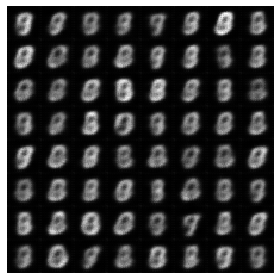

  2%|▏         | 20/1000 [10:53<8:54:44, 32.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 21 	 Current ELBO train: -175.46128845214844
Best elbo validation -180.62572
Current elbo validation -180.62572
Saved samples to ./pics/mnist_epoch_20_K_1_N_1_amortize_False.png


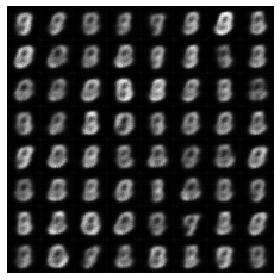

  2%|▏         | 21/1000 [11:26<8:53:48, 32.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 22 	 Current ELBO train: -179.8357696533203
Best elbo validation -180.0662
Current elbo validation -180.0662
Saved samples to ./pics/mnist_epoch_21_K_1_N_1_amortize_False.png


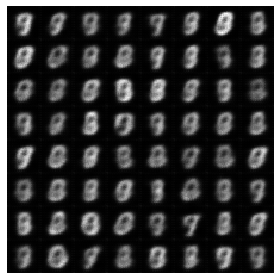

  2%|▏         | 22/1000 [11:58<8:53:01, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 23 	 Current ELBO train: -177.80075073242188
Best elbo validation -179.542
Current elbo validation -179.542
Saved samples to ./pics/mnist_epoch_22_K_1_N_1_amortize_False.png


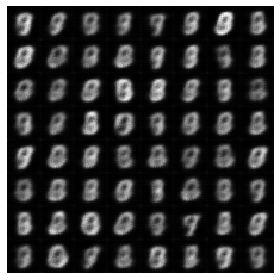

  2%|▏         | 23/1000 [12:31<8:52:17, 32.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 24 	 Current ELBO train: -181.39260864257812
Best elbo validation -179.22427
Current elbo validation -179.22427
Saved samples to ./pics/mnist_epoch_23_K_1_N_1_amortize_False.png


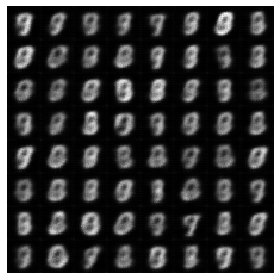

  2%|▏         | 24/1000 [13:04<8:51:41, 32.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 25 	 Current ELBO train: -177.07476806640625
Best elbo validation -179.16681
Current elbo validation -179.16681
Saved samples to ./pics/mnist_epoch_24_K_1_N_1_amortize_False.png


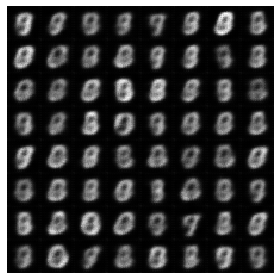

  2%|▎         | 25/1000 [13:36<8:51:01, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.36999999172985554 and for +1: 0.6299999859184027
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 26 	 Current ELBO train: -175.98800659179688
Best elbo validation -179.16681
Current elbo validation -179.34685
Saved samples to ./pics/mnist_epoch_25_K_1_N_1_amortize_False.png


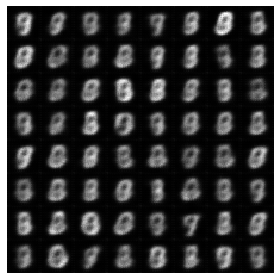

  3%|▎         | 26/1000 [14:09<8:50:17, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 27 	 Current ELBO train: -185.44427490234375
Best elbo validation -178.07187
Current elbo validation -178.07187
Saved samples to ./pics/mnist_epoch_26_K_1_N_1_amortize_False.png


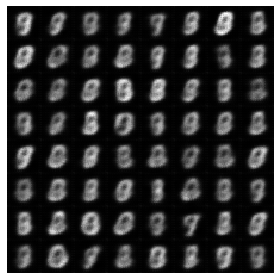

  3%|▎         | 27/1000 [14:42<8:49:46, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 28 	 Current ELBO train: -182.01296997070312
Best elbo validation -178.07187
Current elbo validation -178.3717
Saved samples to ./pics/mnist_epoch_27_K_1_N_1_amortize_False.png


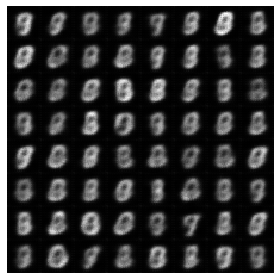

  3%|▎         | 28/1000 [15:14<8:49:10, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 501/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
Current epoch: 29 	 Current ELBO train: -162.3368682861328
Best elbo validation -170.13443
Current elbo validation -170.13443
Saved samples to ./pics/mnist_epoch_28_K_1_N_1_amortize_False.png


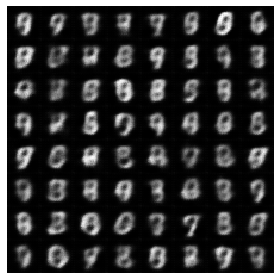

  3%|▎         | 29/1000 [15:47<8:49:12, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 30 	 Current ELBO train: -163.50643920898438
Best elbo validation -163.51678
Current elbo validation -163.51678
Saved samples to ./pics/mnist_epoch_29_K_1_N_1_amortize_False.png


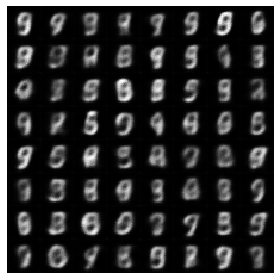

  3%|▎         | 30/1000 [16:20<8:49:03, 32.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 501/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
Current epoch: 31 	 Current ELBO train: -165.51516723632812
Best elbo validation -161.14937
Current elbo validation -161.14937
Saved samples to ./pics/mnist_epoch_30_K_1_N_1_amortize_False.png


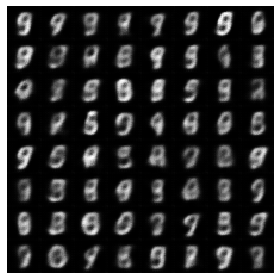

  3%|▎         | 31/1000 [16:53<8:48:16, 32.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 501/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
Current epoch: 32 	 Current ELBO train: -163.28494262695312
Best elbo validation -160.46669
Current elbo validation -160.46669
Saved samples to ./pics/mnist_epoch_31_K_1_N_1_amortize_False.png


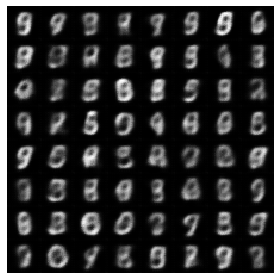

  3%|▎         | 32/1000 [17:25<8:47:28, 32.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 33 	 Current ELBO train: -162.8270263671875
Best elbo validation -160.46669
Current elbo validation -160.89397
Saved samples to ./pics/mnist_epoch_32_K_1_N_1_amortize_False.png


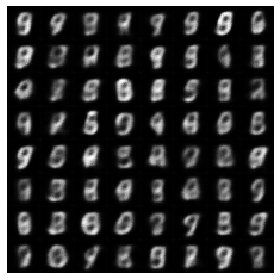

  3%|▎         | 33/1000 [17:58<8:46:39, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.3499999921768904 and for +1: 0.6499999854713678
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 501/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
Current epoch: 34 	 Current ELBO train: -156.96177673339844
Best elbo validation -159.95921
Current elbo validation -159.95921
Saved samples to ./pics/mnist_epoch_33_K_1_N_1_amortize_False.png


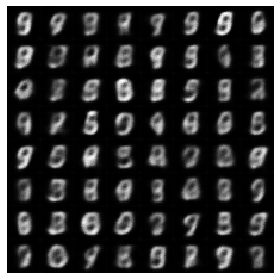

  3%|▎         | 34/1000 [18:31<8:45:58, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 35 	 Current ELBO train: -155.03855895996094
Best elbo validation -159.95921
Current elbo validation -160.26
Saved samples to ./pics/mnist_epoch_34_K_1_N_1_amortize_False.png


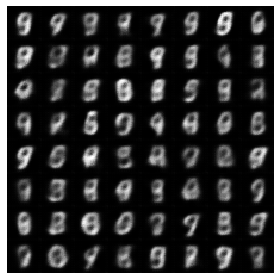

  4%|▎         | 35/1000 [19:03<8:45:15, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 501/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
Current epoch: 36 	 Current ELBO train: -156.78689575195312
Best elbo validation -159.49097
Current elbo validation -159.49097
Saved samples to ./pics/mnist_epoch_35_K_1_N_1_amortize_False.png


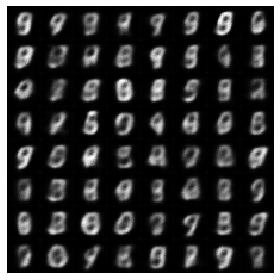

  4%|▎         | 36/1000 [19:36<8:44:41, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 501/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
Current epoch: 37 	 Current ELBO train: -155.8764190673828
Best elbo validation -159.49097
Current elbo validation -160.61038
Saved samples to ./pics/mnist_epoch_36_K_1_N_1_amortize_False.png


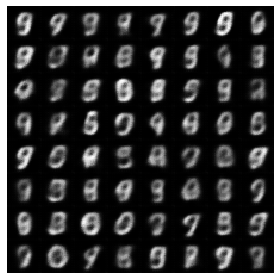

  4%|▎         | 37/1000 [20:09<8:44:07, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 38 	 Current ELBO train: -157.07484436035156
Best elbo validation -159.49097
Current elbo validation -160.19537
Saved samples to ./pics/mnist_epoch_37_K_1_N_1_amortize_False.png


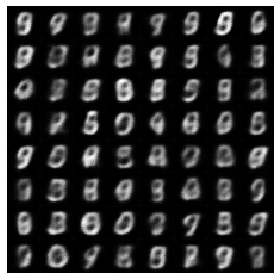

  4%|▍         | 38/1000 [20:41<8:43:37, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 39 	 Current ELBO train: -150.4047088623047
Best elbo validation -153.78284
Current elbo validation -153.78284
Saved samples to ./pics/mnist_epoch_38_K_1_N_1_amortize_False.png


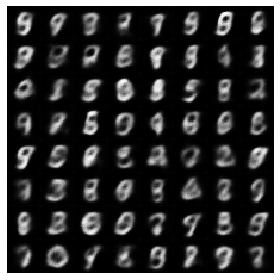

  4%|▍         | 39/1000 [21:14<8:43:41, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 40 	 Current ELBO train: -150.15184020996094
Best elbo validation -151.24106
Current elbo validation -151.24106
Saved samples to ./pics/mnist_epoch_39_K_1_N_1_amortize_False.png


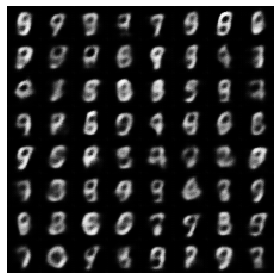

  4%|▍         | 40/1000 [21:47<8:43:42, 32.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 41 	 Current ELBO train: -151.93124389648438
Best elbo validation -149.95602
Current elbo validation -149.95602
Saved samples to ./pics/mnist_epoch_40_K_1_N_1_amortize_False.png


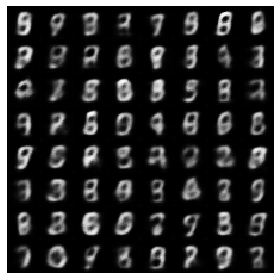

  4%|▍         | 41/1000 [22:19<8:42:49, 32.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 42 	 Current ELBO train: -152.98094177246094
Best elbo validation -149.14197
Current elbo validation -149.14197
Saved samples to ./pics/mnist_epoch_41_K_1_N_1_amortize_False.png


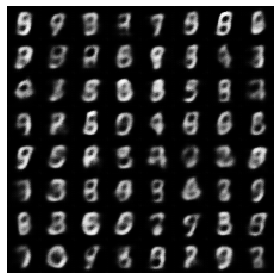

  4%|▍         | 42/1000 [22:52<8:42:01, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 501/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
Current epoch: 43 	 Current ELBO train: -147.49693298339844
Best elbo validation -148.532
Current elbo validation -148.532
Saved samples to ./pics/mnist_epoch_42_K_1_N_1_amortize_False.png


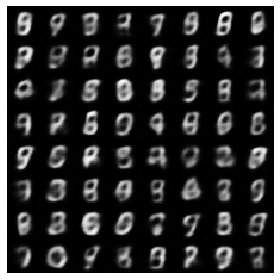

  4%|▍         | 43/1000 [23:25<8:41:19, 32.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
Current epoch: 44 	 Current ELBO train: -149.65611267089844
Best elbo validation -148.532
Current elbo validation -148.78844
Saved samples to ./pics/mnist_epoch_43_K_1_N_1_amortize_False.png


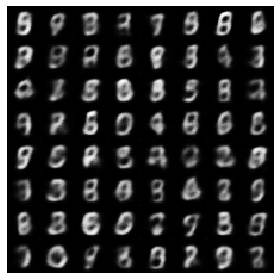

  4%|▍         | 44/1000 [23:57<8:40:34, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
Current epoch: 45 	 Current ELBO train: -150.96633911132812
Best elbo validation -148.532
Current elbo validation -149.01883
Saved samples to ./pics/mnist_epoch_44_K_1_N_1_amortize_False.png


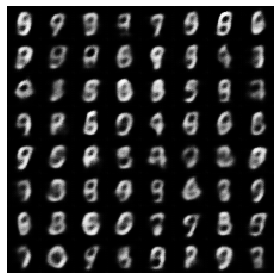

  4%|▍         | 45/1000 [24:30<8:39:52, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 46 	 Current ELBO train: -147.41915893554688
Best elbo validation -148.26558
Current elbo validation -148.26558
Saved samples to ./pics/mnist_epoch_45_K_1_N_1_amortize_False.png


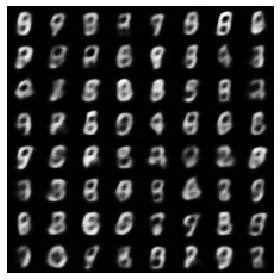

  5%|▍         | 46/1000 [25:03<8:39:19, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 501/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
Current epoch: 47 	 Current ELBO train: -146.40512084960938
Best elbo validation -147.4997
Current elbo validation -147.4997
Saved samples to ./pics/mnist_epoch_46_K_1_N_1_amortize_False.png


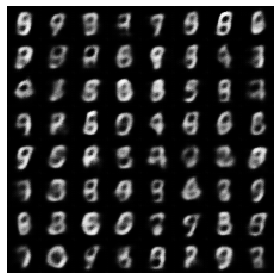

  5%|▍         | 47/1000 [25:35<8:38:46, 32.66s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
Current epoch: 48 	 Current ELBO train: -143.41030883789062
Best elbo validation -147.4997
Current elbo validation -148.4001
Saved samples to ./pics/mnist_epoch_47_K_1_N_1_amortize_False.png


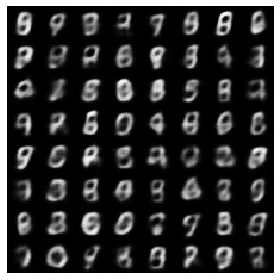

  5%|▍         | 48/1000 [26:08<8:38:19, 32.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 501/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
Current epoch: 49 	 Current ELBO train: -140.84019470214844
Best elbo validation -145.82733
Current elbo validation -145.82733
Saved samples to ./pics/mnist_epoch_48_K_1_N_1_amortize_False.png


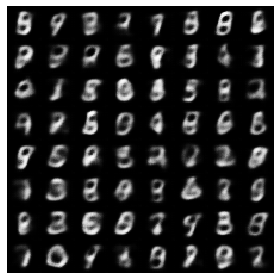

  5%|▍         | 49/1000 [26:41<8:38:19, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 501/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
Current epoch: 50 	 Current ELBO train: -139.9770050048828
Best elbo validation -142.352
Current elbo validation -142.352
Saved samples to ./pics/mnist_epoch_49_K_1_N_1_amortize_False.png


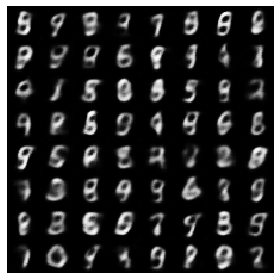

  5%|▌         | 50/1000 [27:14<8:38:08, 32.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 51 	 Current ELBO train: -147.36558532714844
Best elbo validation -141.20691
Current elbo validation -141.20691
Saved samples to ./pics/mnist_epoch_50_K_1_N_1_amortize_False.png


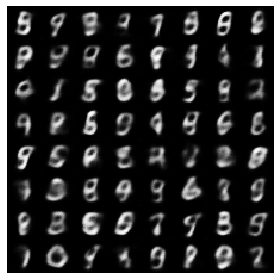

  5%|▌         | 51/1000 [27:46<8:37:13, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 501/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
Current epoch: 52 	 Current ELBO train: -136.78160095214844
Best elbo validation -141.12447
Current elbo validation -141.12447
Saved samples to ./pics/mnist_epoch_51_K_1_N_1_amortize_False.png


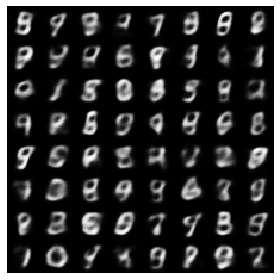

  5%|▌         | 52/1000 [28:19<8:36:43, 32.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 501/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
Current epoch: 53 	 Current ELBO train: -139.64036560058594
Best elbo validation -139.97002
Current elbo validation -139.97002
Saved samples to ./pics/mnist_epoch_52_K_1_N_1_amortize_False.png


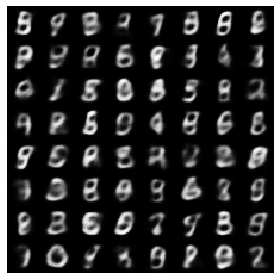

  5%|▌         | 53/1000 [28:52<8:35:52, 32.68s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162


In [ ]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
        #     pdb.set_trace()
            (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
target.decoder.linear1.bias